# Alcohol Boxenplot

Create a boxenplot suitable for showing the effect of categorized ranges of values. <br />
Example showing categorization into groups of 15 (15ml is roughly a glass of wine): <br />
0 -> 0 <br />
12 -> 15 <br />
32 -> 45 <br />

Copyright ©2022. Stephen Rigden. This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

In [1]:
import pandas
from pathlib import Path

import seaborn
from matplotlib import pyplot


seaborn.set_style('darkgrid')  # one of {darkgrid, whitegrid, dark, white, ticks}

In [2]:
# Set file paths
project_path = Path.cwd().parent.parent
heart_and_externals_pickle = project_path / 'data' / 'processed' / 'heart_and_externals.pickle'
alcohol_pdf = project_path / 'reports' / 'alcohol.pdf'
alcohol_jpg = project_path / 'reports' / 'alcohol.jpg'

In [3]:
GLASS_OF_WINE = 15  # ml of alcohol in glass of wine

### Load and view the data

In [4]:
dataset = pandas.read_pickle(heart_and_externals_pickle)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 0 to 111
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            112 non-null    datetime64[ns]
 1   systolic        112 non-null    float64       
 2   diastolic       112 non-null    float64       
 3   pulse pressure  112 non-null    float64       
 4   heart_tablets   112 non-null    Int64         
 5   alcohol         112 non-null    Int64         
dtypes: Int64(2), datetime64[ns](1), float64(3)
memory usage: 6.3 KB


In [5]:
dataset.head()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol
0,2021-12-01 22:30:00,131.0,86.0,45.0,2,0
1,2021-12-01 23:38:00,144.0,79.0,65.0,2,0
2,2021-12-02 00:22:00,140.0,80.0,60.0,2,177
3,2021-12-02 01:16:00,135.0,78.0,57.0,2,177
4,2021-12-02 22:19:00,131.0,70.0,61.0,2,177


In [6]:
dataset.tail()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol
107,2021-12-31 01:19:00,137.0,78.0,59.0,2,30
108,2021-12-31 21:59:00,114.0,70.0,44.0,2,30
109,2021-12-31 23:13:00,134.0,81.0,53.0,2,30
110,2022-01-01 00:11:00,135.0,79.0,56.0,2,106
111,2022-01-01 01:25:00,137.0,81.0,56.0,2,106


### Create alcohol category column

In [7]:
dataset['alcohol_cat'] = dataset.loc[:, 'alcohol'].apply(lambda x: (x - 1) // GLASS_OF_WINE + 1)
dataset.head()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol,alcohol_cat
0,2021-12-01 22:30:00,131.0,86.0,45.0,2,0,0
1,2021-12-01 23:38:00,144.0,79.0,65.0,2,0,0
2,2021-12-02 00:22:00,140.0,80.0,60.0,2,177,12
3,2021-12-02 01:16:00,135.0,78.0,57.0,2,177,12
4,2021-12-02 22:19:00,131.0,70.0,61.0,2,177,12


In [8]:
dataset.tail()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol,alcohol_cat
107,2021-12-31 01:19:00,137.0,78.0,59.0,2,30,2
108,2021-12-31 21:59:00,114.0,70.0,44.0,2,30,2
109,2021-12-31 23:13:00,134.0,81.0,53.0,2,30,2
110,2022-01-01 00:11:00,135.0,79.0,56.0,2,106,8
111,2022-01-01 01:25:00,137.0,81.0,56.0,2,106,8


### Suppress categories of inadequate sample size.

The following code cell offers two ways:
- cutoff based on number of observations
- cutoff based on the percentage of total observations.

In [9]:
# Create a value count dataset
cutoff = 10  # Number of observations
cat_counts = pandas.DataFrame(dataset.loc[:, 'alcohol_cat'].value_counts())
cat_counts['include'] = cat_counts.loc[:, 'alcohol_cat'] > cutoff
cat_counts

# # Create a normalized dataset
# cutoff = 0.05  # Percentage of total observations
# cat_counts = pandas.DataFrame(dataset.loc[:, 'alcohol_cat'].value_counts(normalize=True))
# cat_counts['include'] = cat_counts.loc[:, 'alcohol_cat'] > cutoff
# cat_counts

,alcohol_cat,include
0,40,True
2,37,True
4,8,False
5,8,False
8,5,False
12,4,False
7,4,False
6,4,False
3,2,False


In [10]:
# Convert into a lookup table
cat_counts.reset_index(inplace=True)
cat_counts = cat_counts.drop(['alcohol_cat'], axis=1)
cat_counts = cat_counts.rename(columns={'index': 'alcohol_cat'})
cat_counts

,alcohol_cat,include
0,0,True
1,2,True
2,4,False
3,5,False
4,8,False
5,12,False
6,7,False
7,6,False
8,3,False


In [11]:
# Select rows which are above the cutoff
dataset = dataset.merge(cat_counts, how='left', left_on='alcohol_cat', right_on='alcohol_cat')
dataset = dataset.loc[dataset['include'], :]
dataset.head()

,date,systolic,diastolic,pulse pressure,heart_tablets,alcohol,alcohol_cat,include
0,2021-12-01 22:30:00,131.0,86.0,45.0,2,0,0,True
1,2021-12-01 23:38:00,144.0,79.0,65.0,2,0,0,True
6,2021-12-03 00:11:00,124.0,75.0,49.0,2,0,0,True
7,2021-12-04 01:18:00,146.0,77.0,69.0,2,0,0,True
8,2021-12-04 22:10:00,118.0,67.0,51.0,2,0,0,True


### Plot

[Text(0.5, 0, 'Alcohol as 15ml glasses of wine'),
 Text(0, 0.5, 'observation count')]

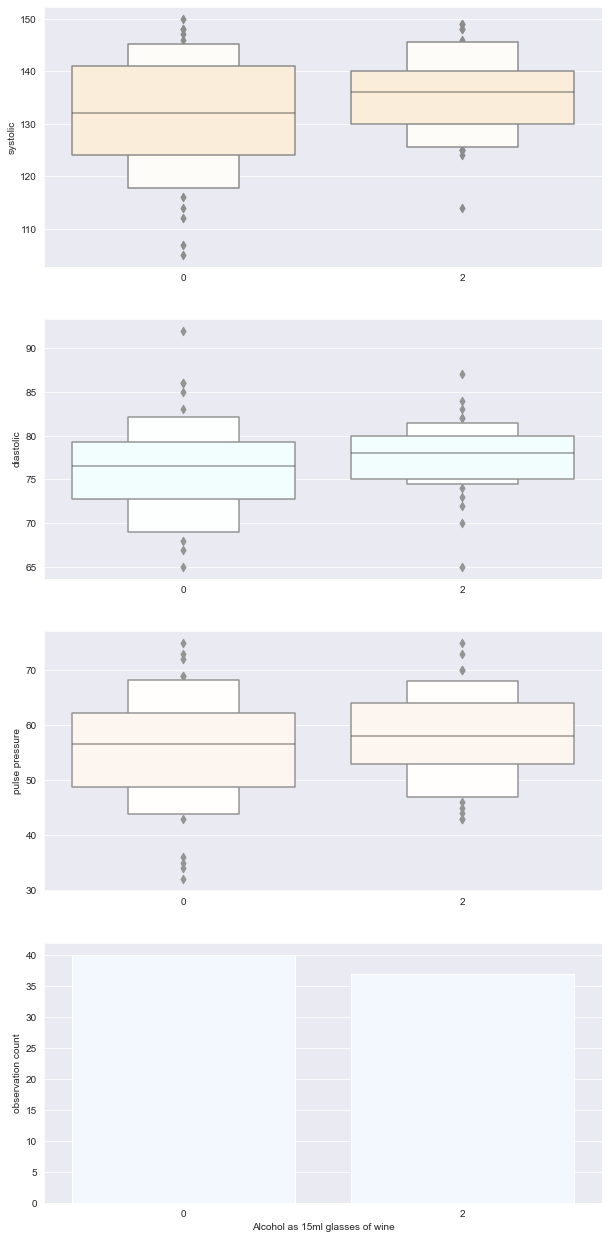

In [12]:
fig, axes = pyplot.subplots(nrows=4, ncols=1, figsize=(10, 22))

# Plot systolic
seaborn.boxenplot(data=dataset,
                  x='alcohol_cat', y='systolic',
                  ax=axes[0], palette=['papayawhip'])

# Plot diastolic
seaborn.boxenplot(data=dataset,
                  x='alcohol_cat', y='diastolic',
                  ax=axes[1], palette=['azure'])

# Plot pulse pressure
seaborn.boxenplot(data=dataset,
                  x='alcohol_cat', y='pulse pressure',
                  ax=axes[2], palette=['seashell'])

# Plot observation counts
seaborn.countplot(data=dataset,
                  x='alcohol_cat',
                  ax=axes[3], palette=['aliceblue'])

axes[0].set(xlabel=None)
axes[1].set(xlabel=None)
axes[2].set(xlabel=None)
axes[3].set(xlabel=f"Alcohol as 15ml glasses of wine", ylabel='observation count')

In [13]:
# Save the plots
fig.savefig(alcohol_jpg)
fig.savefig(alcohol_pdf)